## Melting point predictor for carbon compounds with no benzene substructure

In this notebook the process to evaluate different machine learning models on our data is explained

In [1]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from mordred import Calculator, descriptors, GeometricalIndex, TopologicalIndex 
from rdkit.Chem import Descriptors
from IPython.display import display
# sklearn and models for model training 
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# For fine tuning
from sklearn.model_selection import GridSearchCV
from mordred import Calculator, descriptors, GeometricalIndex, TopologicalIndex
from rdkit.Chem import Descriptors

In [3]:
path_data = Path("../Data/cleaned_data.xlsx")
dataset = pd.read_excel(path_data)
inital_shape = dataset.shape
print(inital_shape)

(19945, 2)


## Restrict the model to less data

As the dataset is very large (nearly 20k data). We'll first restrict our model to a certain type of molecule. This will enable us to familiarize ourselves with machine learning methods without using up too much computational speed. Initially, we'll restrict the analysis to compounds containing only carbon and hydrogen atoms.

In [4]:
# Define a function to check if a SMILES contains only carbon
def contains_carbon(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetSymbol() != "C":
                return False
        return True
    except:
        return False

In [5]:
# Apply the function to the dataset
carbon_dataset = dataset[dataset['smiles'].apply(contains_carbon)]
carbon_dataset.shape

(866, 2)

## Data exploring
We see that we end up with 866 rows, one for each molecule, we have a 2 columns : "smiles" and "mpC" for the melting point in degree celsius. Now we're going to explore our data.

We know from chemistry that for alkanes, the number of carbons is an important factor in the melting point. Let's plot these 2 values for every compounds and see if we observe this trend.

In [37]:
# Counting the number of carbon for every molecule and add this number in a new column

# Function to count the number of carbon atoms in a molecule
def count_carbon(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    carbon_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6)
    return carbon_count

In [7]:
# Add a new column 'carbon_count' to the DataFrame
carbon_dataset['carbon_count'] = carbon_dataset['smiles'].apply(count_carbon)

/var/folders/qy/8nbc5kyd0fd_60v_krw9dwf40000gp/T/ipykernel_13615/1337822114.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_dataset['carbon_count'] = carbon_dataset['smiles'].apply(count_carbon)


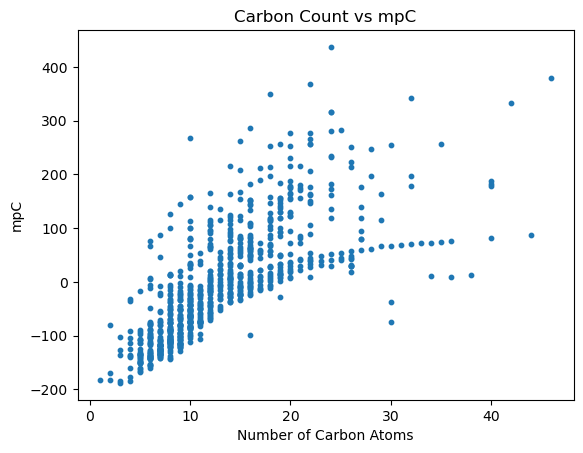

In [12]:
# Plot mpC vs Carbon_count


plt.scatter(carbon_dataset['carbon_count'], carbon_dataset['mpC'], s=10)
plt.xlabel('Number of Carbon Atoms')
plt.ylabel('mpC')
plt.title('Carbon Count vs mpC')
plt.show()

We are indeed seeing the expected trend, with a curve emerging in our scatterplot. 
Some molecules seem to have a much higher melting point than others. We know that the presence of benzene can affect the melting point through pi-stacking interactions. Let's display the 20 molecules with the highest melting point to verify this. 

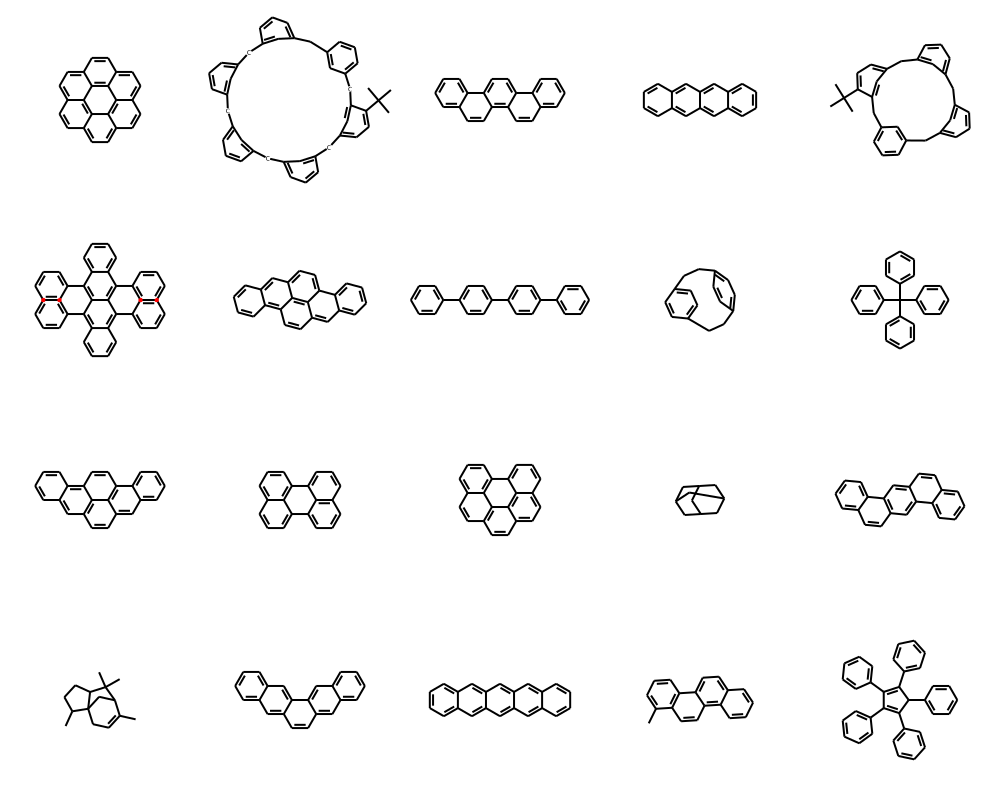

In [13]:
# See wich molecules have a high melting point
number_of_molecules_to_display = 20

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = carbon_dataset.sort_values(by='mpC', ascending=False)

# Get the top molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Draw the molecules in a grid
imge = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
display(imge)

Indeed, we can see that most of the compounds with the highest melting points have benzene as a substructure. We also note that all molecules with high melting points are highly symmetrical. \

**Let's see if the plot is different without compounds having benzene as substructure :**

In [15]:
# See if we remove molecules with substructure benzene

# Function to check for benzene substructure
def has_benzene_substructure(smiles):
    mol = Chem.MolFromSmiles(smiles)
    benzene_substructure = Chem.MolFromSmarts('c1ccccc1')
    return mol.HasSubstructMatch(benzene_substructure)

# Add a new column 'has_benzene_sub' to the DataFrame
carbon_dataset['has_benzene_sub'] = carbon_dataset['smiles'].apply(has_benzene_substructure)

/var/folders/qy/8nbc5kyd0fd_60v_krw9dwf40000gp/T/ipykernel_13615/620376247.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_dataset['has_benzene_sub'] = carbon_dataset['smiles'].apply(has_benzene_substructure)


In [16]:
# Selecting only molecules without benzene substructure
dataset_no_benzene = carbon_dataset[carbon_dataset['has_benzene_sub'] != True]

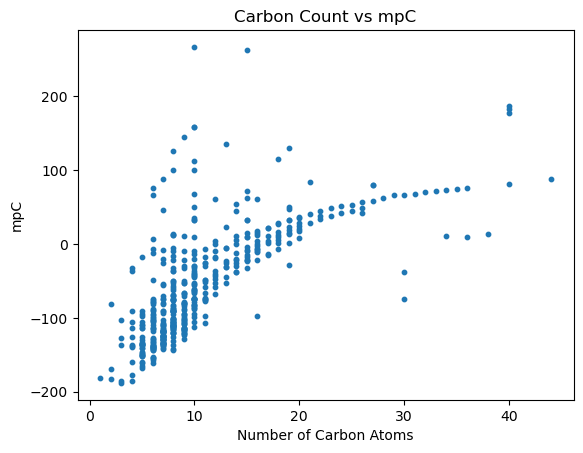

In [17]:
# See the plot without benzene 

plt.scatter(dataset_no_benzene['carbon_count'], dataset_no_benzene['mpC'], s=10)
plt.xlabel('Number of Carbon Atoms')
plt.ylabel('mpC')
plt.title('Carbon Count vs mpC')
plt.show()

We can see that the plot is very different, with maximum values at around 200°C, compared with around 400°C before when including the benzene substructure. We also observe that 2 molecules are very different from the others, with few carbons but a high melting point. Let's display these molecules with their melting point :

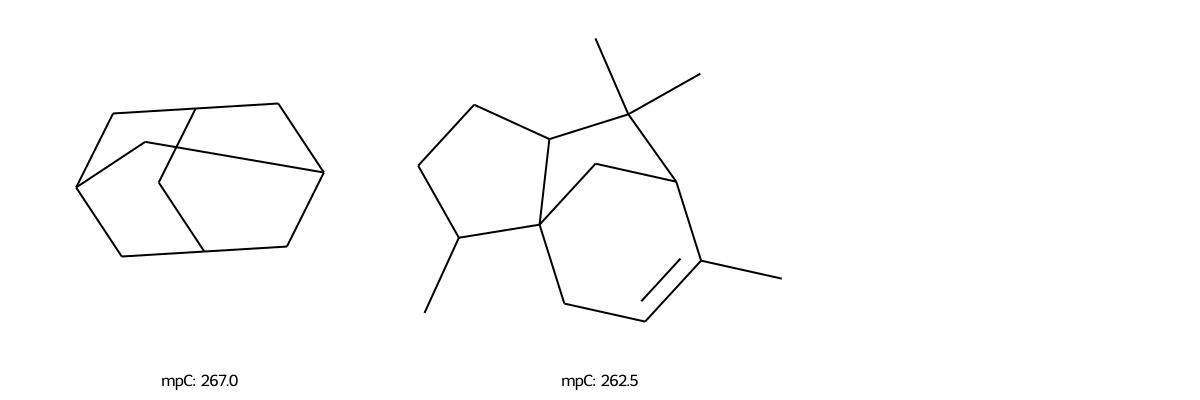

In [18]:
# Number of molecules to display
number_of_molecules_to_display = 2

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = dataset_no_benzene.sort_values(by='mpC', ascending=False)

# Get the top molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Create legend text with melting point values
legend_texts = [f"mpC: {mp}" for mp in top_molecules['mpC']]

# Draw the molecules in a grid with legend
img = Draw.MolsToGridImage(mols, legends=legend_texts, subImgSize=(400, 400))
display(img)

## Model training

In order to create a model, we need features for each molecules that the model will use to predict the melting point. We will use the "mordred descritptors", we first need to calculate all mordred descriptors for all molecules from the dataset_no_benzene. As this takes a long time to run, it has already been done and the result saved with :
\
\
*df_combined.to_excel('non_benzene_descriptors.xlsx', index=False)*
\
\
the name of the dataset is then "non_benzene_descriptors.xlsx".

In [19]:
"""
# Function to calculate all Mordred descriptors for a given SMILES string
def calculate_all_mordred_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    calc = Calculator(descriptors)
    mordred_descriptors = calc(mol)
    return mordred_descriptors.fill_missing().asdict()

# List to store dictionaries of descriptors for each molecule
descriptor_dicts = []

# Iterate over each SMILES string and calculate descriptors
for smiles in dataset_no_benzene['smiles']:
    descriptor_dict = calculate_all_mordred_descriptors(smiles)
    descriptor_dicts.append(descriptor_dict)

# Convert the list of dictionaries into a DataFrame
df_descriptors = pd.DataFrame(descriptor_dicts)

# Reset the indices of df and df_descriptors
dataset_no_benzene.reset_index(drop=True, inplace=True)
df_descriptors.reset_index(drop=True, inplace=True)

# Concatenate df and df_descriptors along the columns axis (axis=1)
df_combined = pd.concat([dataset_no_benzene, df_descriptors], axis=1)

# Save df_combined as an Excel file
df_combined.to_excel('non_benzene_descriptors.xlsx', index=False)
"""

"\n# Function to calculate all Mordred descriptors for a given SMILES string\ndef calculate_all_mordred_descriptors(smiles):\n    mol = Chem.MolFromSmiles(smiles)\n    calc = Calculator(descriptors)\n    mordred_descriptors = calc(mol)\n    return mordred_descriptors.fill_missing().asdict()\n\n# List to store dictionaries of descriptors for each molecule\ndescriptor_dicts = []\n\n# Iterate over each SMILES string and calculate descriptors\nfor smiles in dataset_no_benzene['smiles']:\n    descriptor_dict = calculate_all_mordred_descriptors(smiles)\n    descriptor_dicts.append(descriptor_dict)\n\n# Convert the list of dictionaries into a DataFrame\ndf_descriptors = pd.DataFrame(descriptor_dicts)\n\n# Reset the indices of df and df_descriptors\ndataset_no_benzene.reset_index(drop=True, inplace=True)\ndf_descriptors.reset_index(drop=True, inplace=True)\n\n# Concatenate df and df_descriptors along the columns axis (axis=1)\ndf_combined = pd.concat([dataset_no_benzene, df_descriptors], axis=

In [4]:
# Load the saved dataset with Mordred descriptors
path_descriptors = Path("/Users/malogfeller/git/Ppchem-MP-predictor/Alcane_analysis/non_benzene_descriptors.xlsx")
df_combined = pd.read_excel(path_descriptors)
df_combined.shape

(486, 1830)

### Cleaning the features
We now have our descriptors that will be used to predict the melting point. As we have not selected manually the descriptors, some of them will be irrelevant. For example, the descriptor "HBondAcceptor" is not useful as we only have carbon compounds, none of them will have Hbond abilities. Also, we may have some descriptors that describe the same thing (highly correlated descriptors), so only one of them is useful to train the model. \
Because of this, we will remove low variance descriptors, and keep only 1 descriptors if we have a set of highly correlated descriptors.

In [6]:
# Extracting only descriptors
descriptors = df_combined.drop(columns=['smiles', 'mpC'])

In [8]:
# Calculate the variance for each column
column_variances = descriptors.var()

# Specify a threshold for variance
threshold = 0.05

# Filter out columns with variance below the threshold
columns_to_keep = column_variances[column_variances >= threshold].index

# Create a new DataFrame without low variance columns
df_high_variance = df_combined[columns_to_keep]

# Calculate the absolute correlation matrix and get the upper triangle
upper_triangle = df_high_variance.corr().abs().where(np.triu(np.ones(df_high_variance.shape[1]), k=1).astype(bool))

# Identify columns with correlation greater than 0.95
columns_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95)]

# Drop the highly correlated columns
df_low_corr = df_high_variance.drop(columns=columns_to_drop)

df_low_corr.shape

(486, 227)

Now that we have columns with low variance and low correlation, we need to check whether we have any NaN values in the dataset, as this type of value can be difficult for an ML model to handle.

In [9]:
# Count the NaN values across the entire DataFrame
total_nans = df_low_corr.isna().sum().sum()

print(f"Total number of NaN values in the DataFrame: {total_nans}")

Total number of NaN values in the DataFrame: 9347


We see that we have many NaN values, in machine learning, there's many different ways to handle NaN values. Here we will explore the distribution of this values to see the best way to remove them. First, the calculation of specific may have outputed NaN values for all (or most of) molecules, let see the top 20 columns with the most NaN values :

In [10]:
pd.set_option('display.max_rows', None) 
# Count the NaN values in each column
nans_per_column = df_low_corr.isna().sum()

# Sort the counts in descending order and select the top 20
top_20_nan_columns = nans_per_column.sort_values(ascending=False).head(20)

# Print the 20 columns with the most NaN values
print("Top 20 columns with the most NaN values:")
print(top_20_nan_columns)
print(df_low_corr.shape)

Top 20 columns with the most NaN values:
MDEC-44     461
MAXtCH      456
MDEC-34     438
MDEC-33     359
AATSC8Z     273
GATS8c      273
AATS8s      273
GATS8s      273
AATS8Z      273
AATSC8dv    273
AATS8dv     273
GATS8d      273
AATS8d      273
MATS8s      273
GATS8dv     273
MDEC-13     213
MDEC-23     207
GATS7d      196
MATS7dv     196
MATS7c      196
dtype: int64
(486, 227)


We have many columns with nearly all row having a NaN values, we will delete those columns as they do not give any information about the molecule. However, we don't want to remove all columns containing NaN values because if a column contains only 1 NaN values, deleting this column will result in a significant loss of information (N-1 potentially useful values will be deleted with no reason).
\
Because of this, the arbitrary following choice has been done :
\
\
- If over the 95% of rows contain NaN values for a given descriptor, the corresponding descriptors will be deleted. 
\ 
- If more than the 95% of values for a given descriptor are non-NaN, all NaN values will be filled up with the mean values of the descriptor

In [11]:
# Define the threshold for removing columns (as a % of total rows)
threshold = 0.95 

# Calculate the number of NaN values per column
nans_per_column = df_low_corr.isna().sum()

# Calculate the total number of rows
total_rows = len(df_low_corr)

# Remove columns where the number of NaN is greater than the threshold
columns_to_drop = nans_per_column[nans_per_column > threshold * total_rows].index
df_dropped = df_low_corr.drop(columns=columns_to_drop)

# Fill remaining NaNs with the mean of each column
for col in df_dropped:  
    if df_dropped[col].isna().sum() > 0:  
        df_dropped[col] = df_dropped[col].fillna(df_dropped[col].mean())

df_dropped.shape

(486, 227)

We have now a clean dataframe with all descriptors. Let's add back smiles and melting point and save it to use it later :

In [17]:
"""
selected_df = df_combined[["smiles", "mpC"]]
no_benzene_for_train = pd.concat([selected_df, df_dropped], axis=1)

# Save the final dataset as an Excel file
no_benzene_for
_train.to_excel('no_benzene_for_train.xlsx', index=False)
"""

# Load the final dataset
path_final = Path("/Users/malogfeller/git/Ppchem-MP-predictor/Alcane_analysis/no_benzene_for_train.xlsx")
no_benzene_for_train = pd.read_excel(path_final)

In [19]:
no_benzene_for_train.shape

(486, 229)

## Try and train models
Now that we have clean descriptors we can start to train models on the data. Input values (X) are all descriptors and the target value to predict (y) is the melting point.
\
Here we will loop across a list of common ML model to test them all. In order to evaluate wich one is the best we will print for each model the mean squared error and the R^2. We will also plot "predicted vs actual melting point" and "residus vs predicted melting point". 

Random Forest Regressor - MSE: 749.83, R2: 0.85


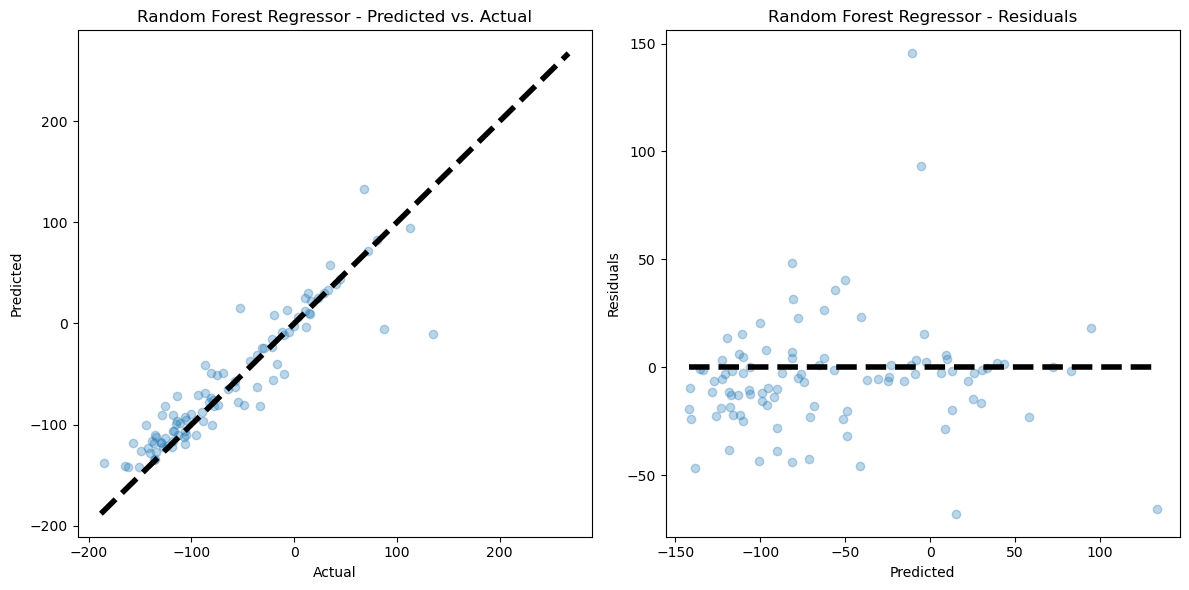

Gradient Boosting Regressor - MSE: 818.17, R2: 0.83


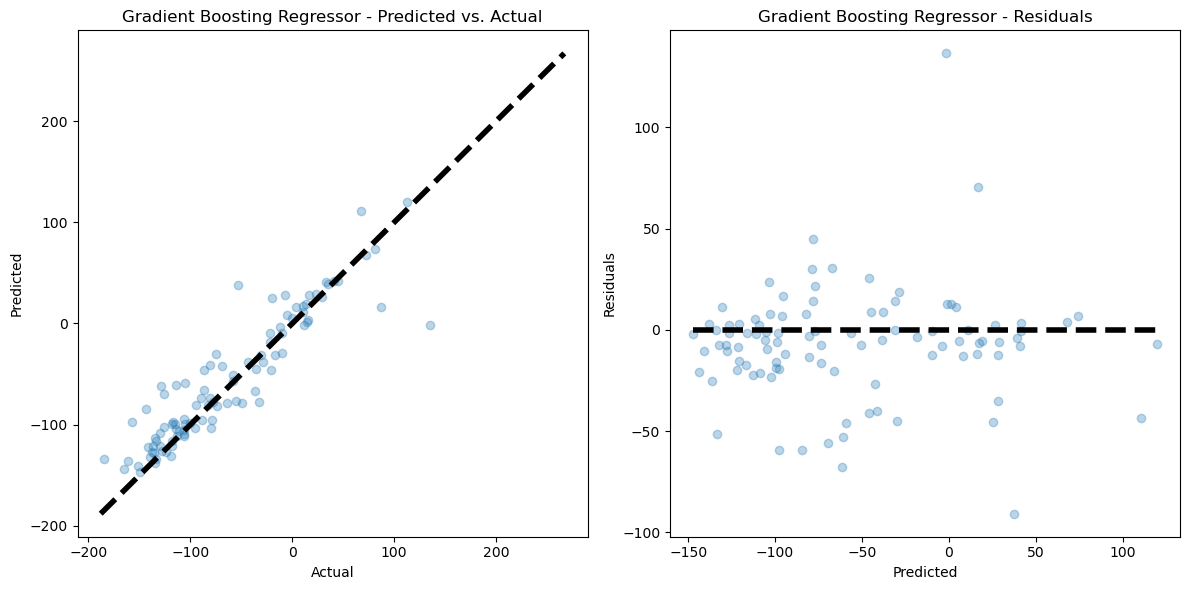

K Neighbors Regressor - MSE: 1444.41, R2: 0.70


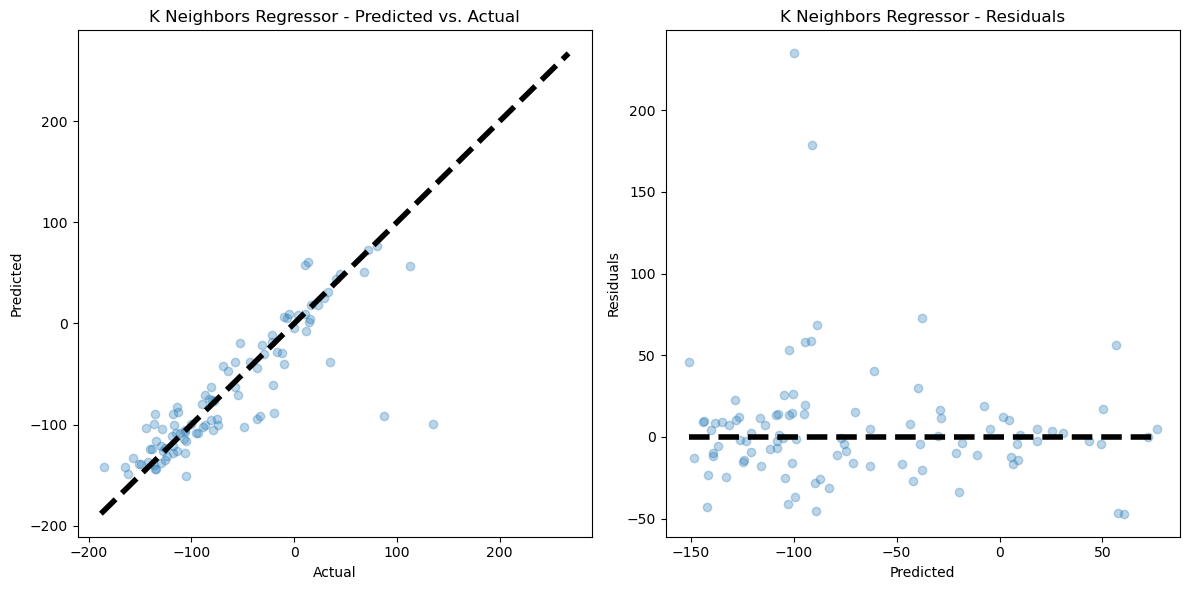

Decision Tree Regressor - MSE: 2150.14, R2: 0.56


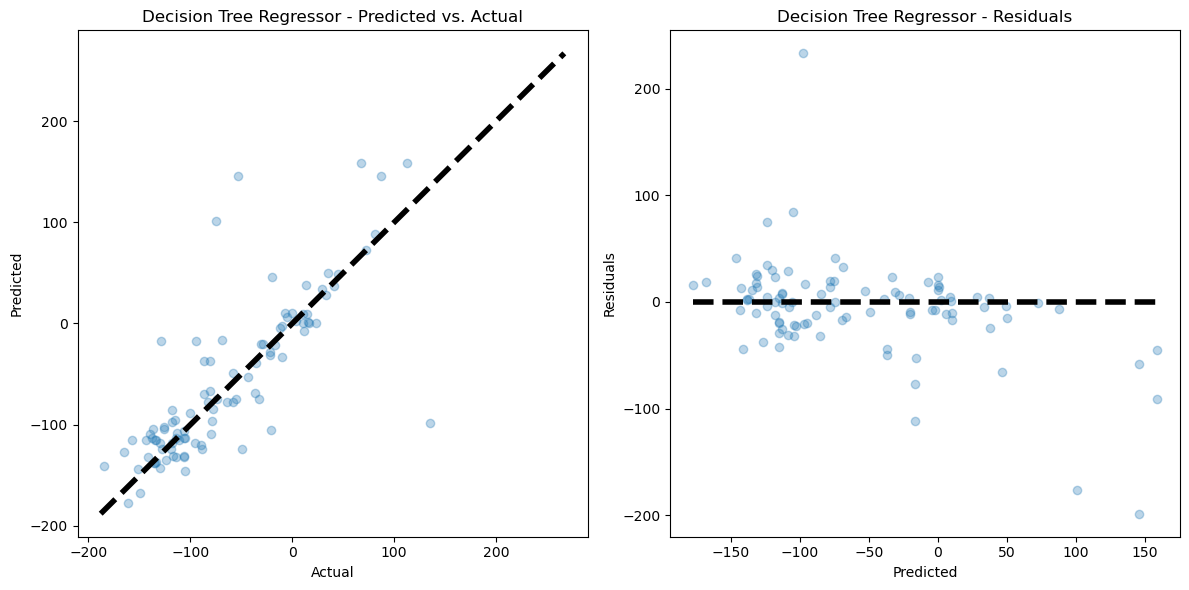

XGBoost - MSE: 1105.28, R2: 0.77


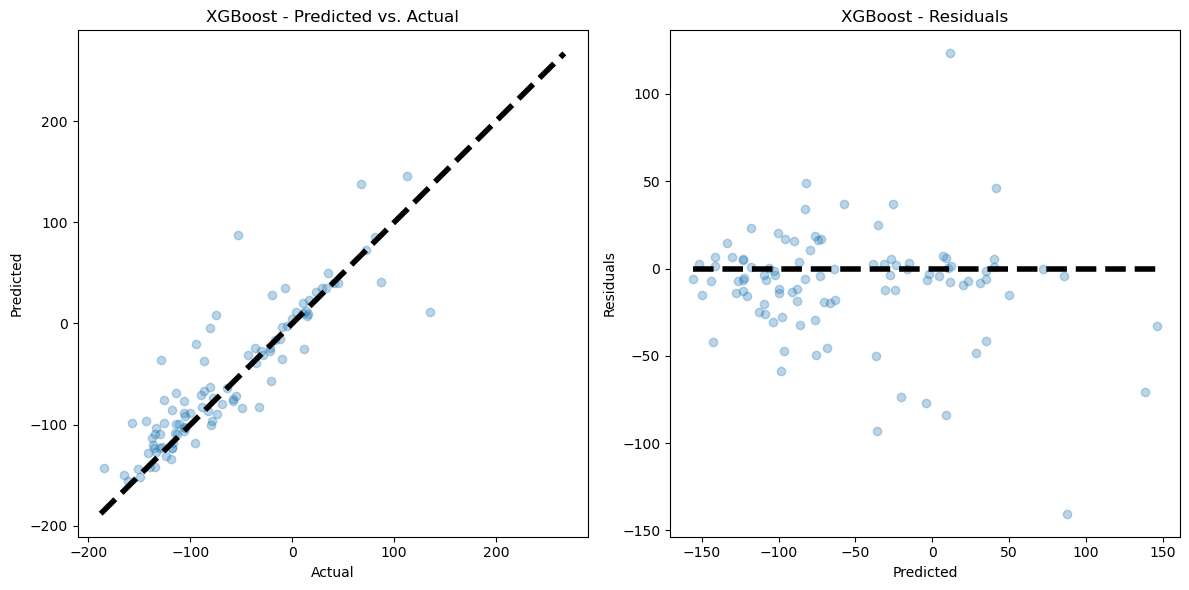

LightGBM - MSE: 904.29, R2: 0.81


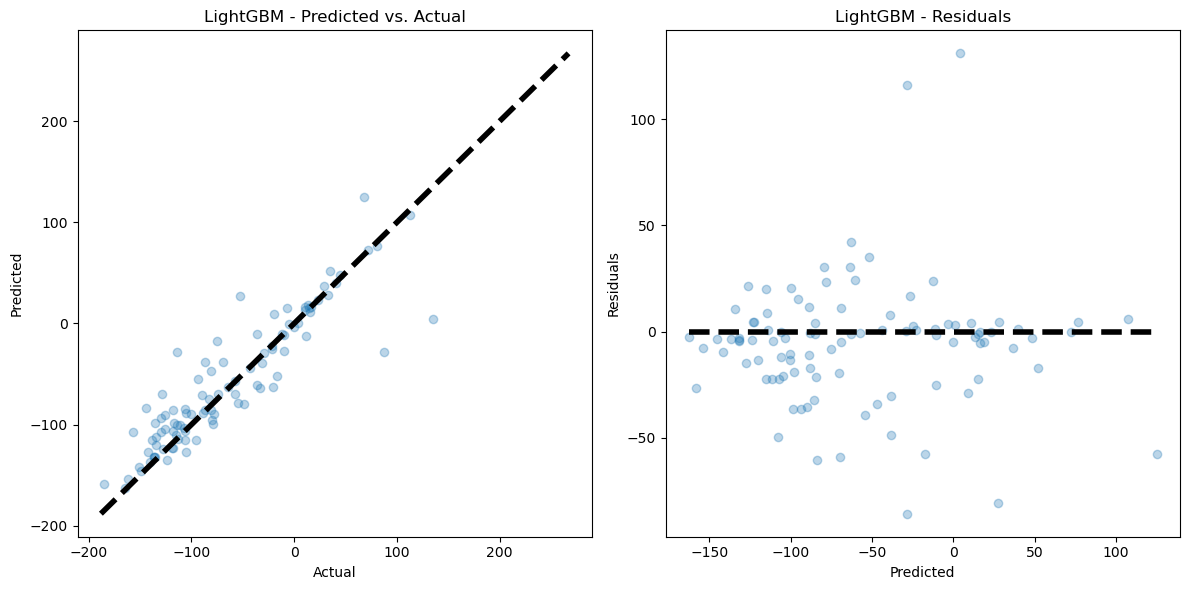

In [15]:
# Separating the features and the target variable
X = no_benzene_for_train.drop(columns=['smiles', 'mpC'])  
y = no_benzene_for_train['mpC']  

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary of models for ease of iteration
models = {
    'Random Forest Regressor': RandomForestRegressor(random_state=123),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=123),
    'K Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=123),
    'XGBoost': XGBRegressor(random_state=123),
    'LightGBM': LGBMRegressor(random_state=123)
}

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name} - Predicted vs. Actual')
    
# Plotting Residuals
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'{name} - Residuals')
    
    plt.tight_layout()
    plt.show()

Without any hyperparameter tunning the best performing models are :


- RandomForest
- Gradient Boosting
- LightGBM

Those 3 models are selected for hyperparameter tunning. 
As a grid search can be very demanding in terms of computing power. The following code has been executed in google colab and the best hyperparameters found are reported.

### Hyperparameters tunning for RandomForest

In [20]:
"""
# Define the model
rf = RandomForestRegressor(random_state=123)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [50, 100, 250],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']  
}

# Setup and perform the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Extract best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
"""

'\n# Define the model\nrf = RandomForestRegressor(random_state=123)\n\n# Define the parameters grid to search\nparam_grid = {\n    \'n_estimators\': [50, 100, 250],  \n    \'max_depth\': [None, 10, 20],  \n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'auto\', \'sqrt\']  \n}\n\n# Setup and perform the grid search\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'neg_mean_squared_error\')\ngrid_search.fit(X_train, y_train)\n\n# Extract best parameters\nprint("Best parameters:", grid_search.best_params_)\n\n# Best model\nbest_rf = grid_search.best_estimator_\n\n# Predictions and evaluation\ny_pred = best_rf.predict(X_test)\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\nprint(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")\n'

After tuning RandomForestRegressor - MSE: 1051.53, R2: 0.80


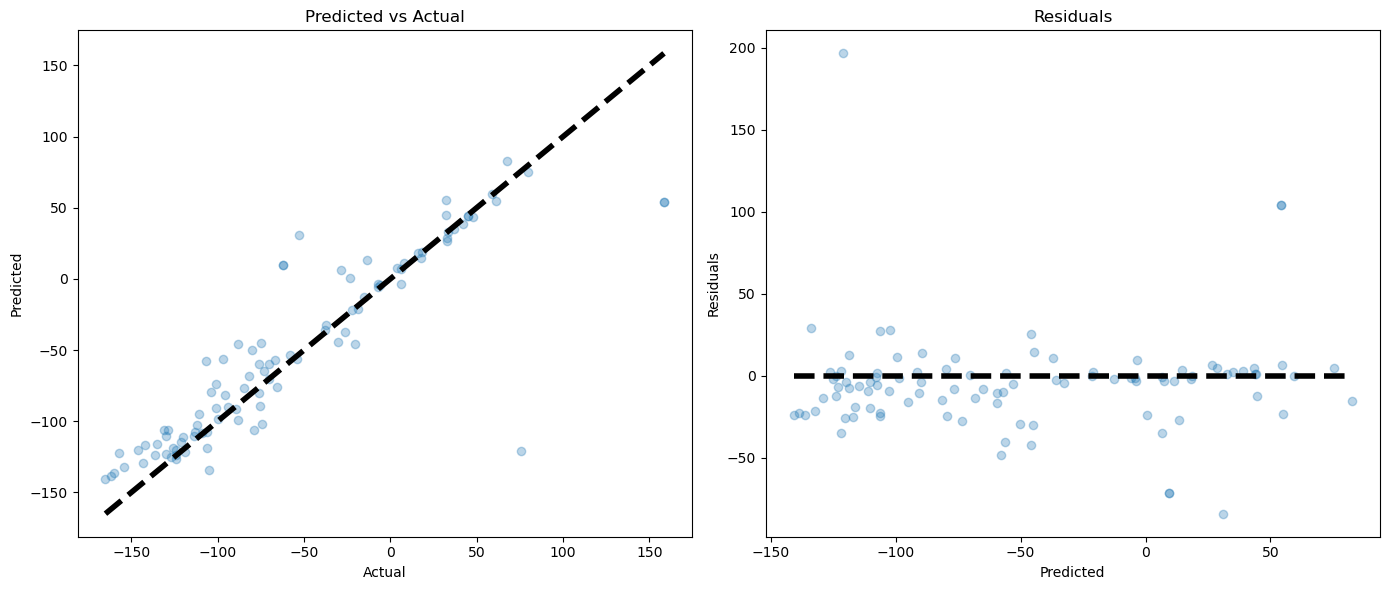

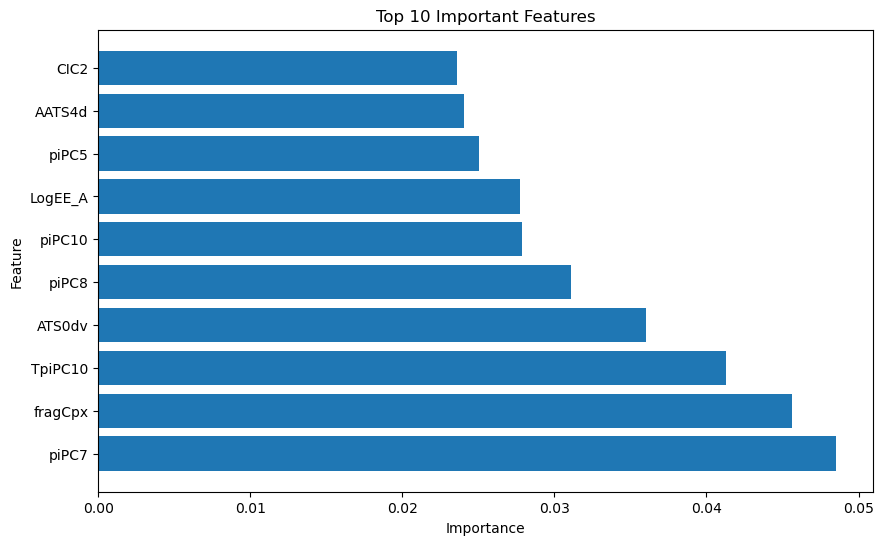

In [26]:
# visualize result for the best random forest model

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the model with the best parameters
rf_best = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

# Fit the model
rf_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning RandomForestRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')

# Plotting Residuals
residuals = y_test - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.3)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances = rf_best.feature_importances_
features = np.array(X_train.columns)
df_feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
df_sorted = df_feature_importances.sort_values('importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['feature'], df_sorted['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.show()

### Hyperparameters tunning for GradientBoosting

In [23]:
"""
# Define the model
gb = GradientBoostingRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],  
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_gb = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_gb.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
"""

'\n# Define the model\ngb = GradientBoostingRegressor(random_state=42)\n\n# Define the parameters grid to search\nparam_grid = {\n    \'n_estimators\': [100, 200],  \n    \'learning_rate\': [0.01, 0.1],  \n    \'max_depth\': [3, 5, 7],  \n    \'min_samples_split\': [2, 4],\n    \'min_samples_leaf\': [1, 2],\n}\n\n# Setup the grid search\ngrid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'neg_mean_squared_error\')\n\n# Perform the grid search\ngrid_search.fit(X_train_scaled, y_train)\n\n# Best parameters\nprint("Best parameters:", grid_search.best_params_)\n\n# Best model\nbest_gb = grid_search.best_estimator_\n\n# Predictions and evaluation\ny_pred = best_gb.predict(X_test_scaled)\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\nprint(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")\n'

After tuning GradientBoostingRegressor - MSE: 1142.59, R2: 0.78


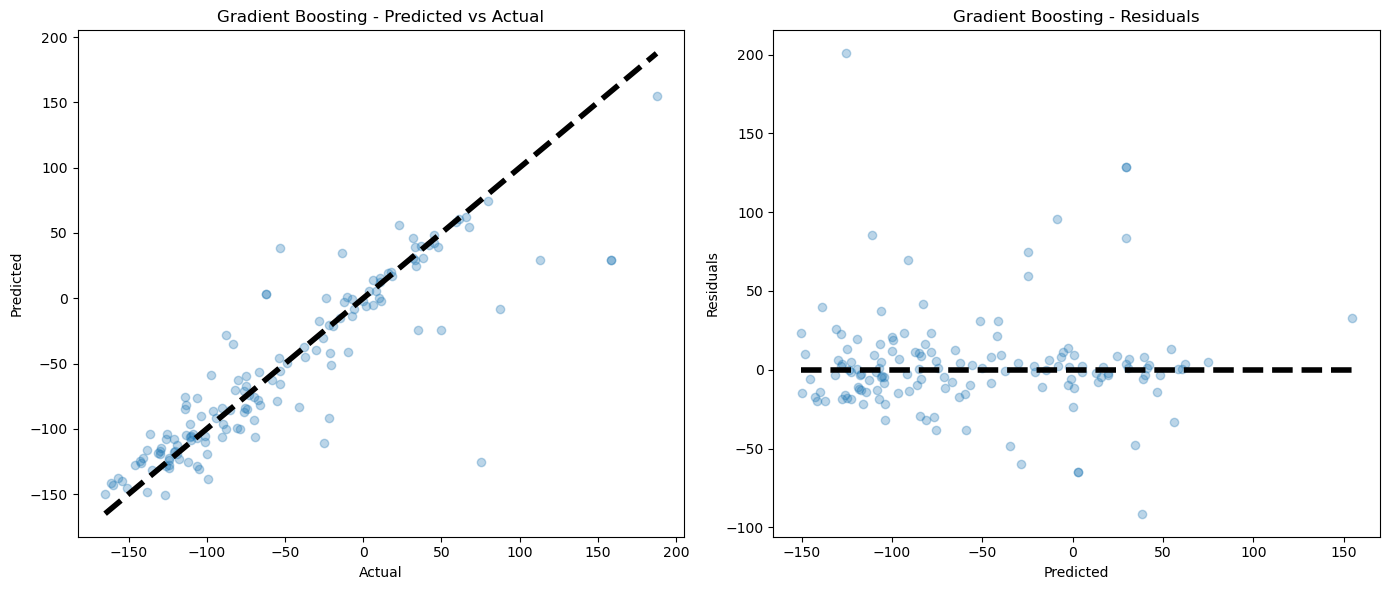

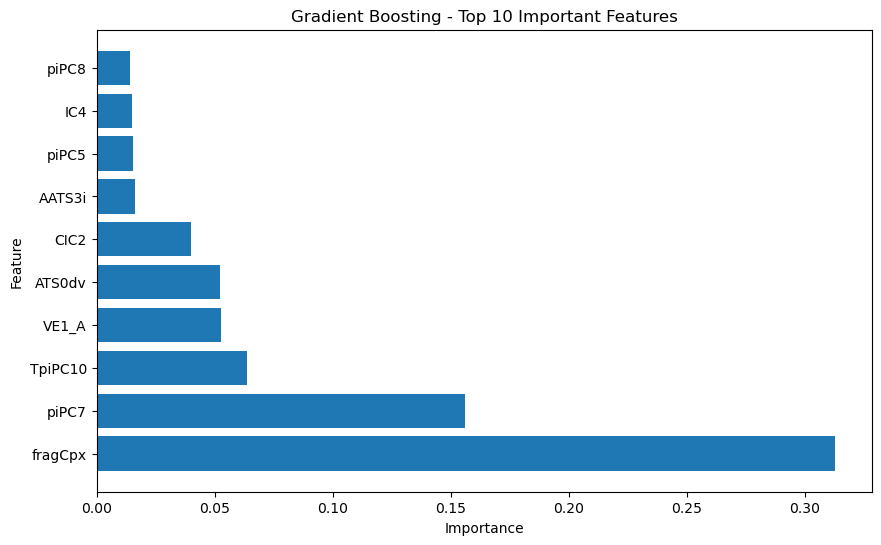

In [49]:

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Creating the model with the best parameters
gb_best = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200)

# Fitting the model
gb_best.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = gb_best.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)
print(f"After tuning GradientBoostingRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting - Predicted vs Actual')

# Plotting Residuals
residuals_gb = y_test - y_pred_gb

plt.subplot(1, 2, 2)

plt.scatter(y_pred_gb, residuals_gb, alpha=0.3)
plt.plot([y_pred_gb.min(), y_pred_gb.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Gradient Boosting - Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances_gb = gb_best.feature_importances_
df_feature_importances_gb = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances_gb})
df_sorted_gb = df_feature_importances_gb.sort_values('importance', ascending=False).head(10)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(df_sorted_gb['feature'], df_sorted_gb['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting - Top 10 Important Features')
plt.show()

In [24]:
"""
# Define the model
lgbm = LGBMRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 40],
    'min_child_weight': [0.001, 0.01],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_lgbm = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_lgbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
"""

'\n# Define the model\nlgbm = LGBMRegressor(random_state=42)\n\n# Define the parameters grid to search\nparam_grid = {\n    \'n_estimators\': [100, 200],\n    \'learning_rate\': [0.01, 0.1],\n    \'max_depth\': [3, 5, 7],\n    \'num_leaves\': [31, 63],\n    \'min_child_samples\': [20, 40],\n    \'min_child_weight\': [0.001, 0.01],\n    \'subsample\': [0.5, 0.7, 1.0],\n    \'colsample_bytree\': [0.5, 0.7, 1.0]\n}\n\n# Setup the grid search\ngrid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'neg_mean_squared_error\')\n\n# Perform the grid search\ngrid_search.fit(X_train, y_train)\n\n# Best parameters\nprint("Best parameters:", grid_search.best_params_)\n\n# Best model\nbest_lgbm = grid_search.best_estimator_\n\n# Predictions and evaluation\ny_pred = best_lgbm.predict(X_test)\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\n\nprint(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")\n'

After tuning LGBMRegressor - MSE: 1216.67, R2: 0.77


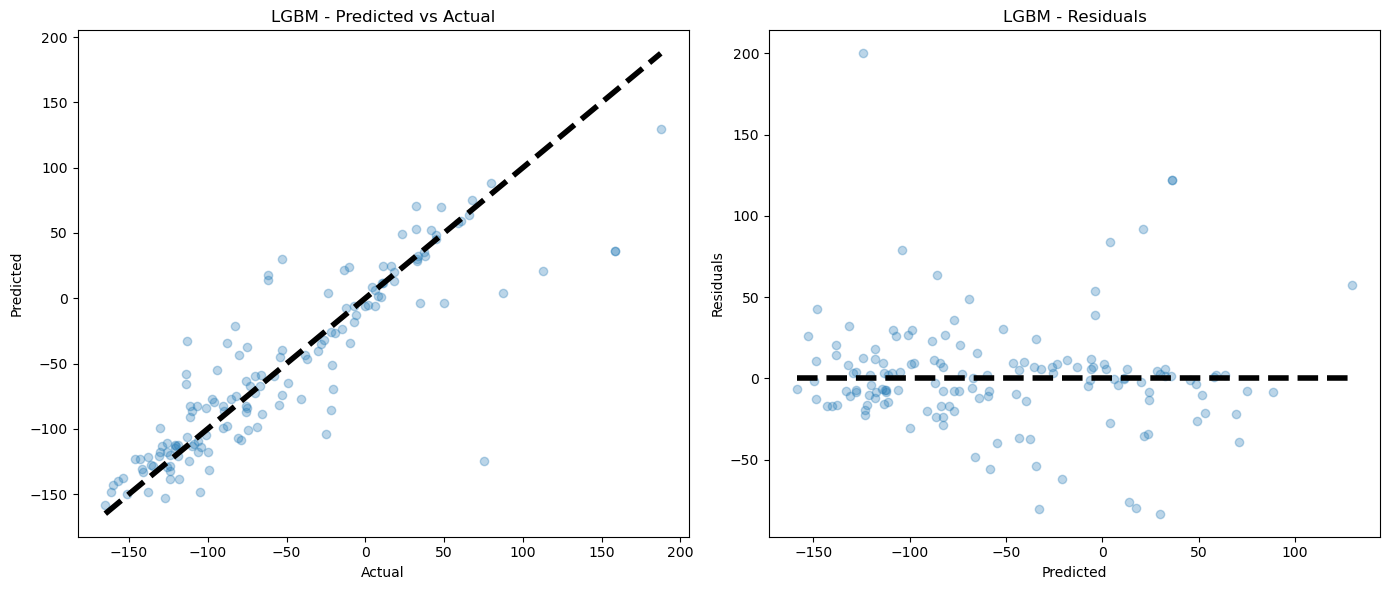

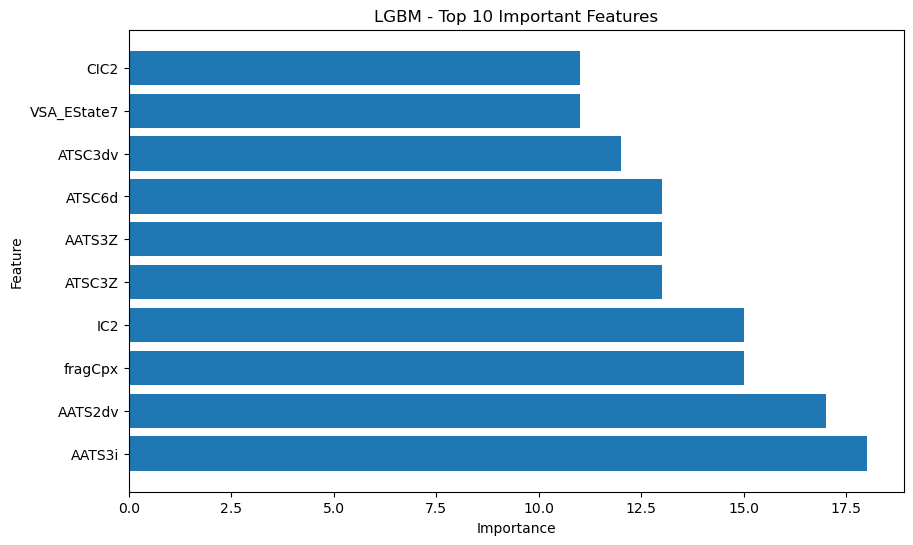

In [26]:
# Splitting the dataset into training and testing setX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating the model with the best parameters
lgbm_best = LGBMRegressor(colsample_bytree = 0.5, learning_rate = 0.1, max_depth= 5, min_child_samples= 20, min_child_weight=0.001, n_estimators= 100, num_leaves=31, subsample = 0.5)

# Fitting the model
lgbm_best.fit(X_train_scaled, y_train)

# Predictions
y_pred_lgbm = lgbm_best.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_lgbm)
r2 = r2_score(y_test, y_pred_lgbm)
print(f"After tuning LGBMRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lgbm, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LGBM - Predicted vs Actual')

# Plotting Residuals
residuals_lgbm = y_test - y_pred_lgbm

plt.subplot(1, 2, 2)
plt.scatter(y_pred_lgbm, residuals_lgbm, alpha=0.3)
plt.plot([y_pred_lgbm.min(), y_pred_lgbm.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('LGBM - Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances_lgbm = lgbm_best.feature_importances_
df_feature_importances_lgbm = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances_lgbm})
df_sorted_lgbm = df_feature_importances_lgbm.sort_values('importance', ascending=False).head(10)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(df_sorted_lgbm['feature'], df_sorted_lgbm['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('LGBM - Top 10 Important Features')
plt.show()

# Try the model on another Dataset

In [53]:
import joblib

# Save the rf_best trained on all data
rf_best.fit(X,y)

# Save the model to a file
joblib.dump(rf_best, 'rf_nonbenzene_model.pkl')

# Load rf_best model from file
rf_best = joblib.load('rf_nonbenzene_model.pkl')

In [86]:
# Try gb_best on validation_descriptors
validation = pd.read_csv("/Users/malogfeller/git/Ppchem-MP-predictor/Data/validation_descriptors.csv")

# Add a carbon count column with index 3 to the dataset
validation['carbon_count'] = validation['SMILES'].apply(count_carbon)

# Get the intersection of columns between X and data
common_columns = X.columns.intersection(validation.columns)

# Filter data DataFrame to keep only the common columns
filtered_data = validation[common_columns]

# Fill NaN values with mean
for col in filtered_data:  
    if filtered_data[col].isna().sum() > 0:  
        filtered_data[col] = filtered_data[col].fillna(filtered_data[col].mean())

y_validation = validation['Ave °C']

/var/folders/qy/8nbc5kyd0fd_60v_krw9dwf40000gp/T/ipykernel_33744/1171758337.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = filtered_data[col].fillna(filtered_data[col].mean())


In [82]:
# Look if there are NaN values 
total_nans = filtered_data.isna().sum().sum()
print(f"Total number of NaN values in the DataFrame: {total_nans}")

Total number of NaN values in the DataFrame: 152


In [80]:
filtered_data_scaled = scaler.transform(filtered_data)
prediciton = gb_best.predict(filtered_data_scaled)


mse = mean_squared_error(y_validation, prediciton)
r2 = r2_score(y_validation, prediciton)
print(f"After tuning GradientBoostingRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_validation, prediciton, alpha=0.3)
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting - Predicted vs Actual')

# Plotting Residuals
residuals_gb = y_validation - prediciton

plt.subplot(1, 2, 2)

plt.scatter(prediciton, residuals_gb, alpha=0.3)
plt.plot([prediciton.min(), prediciton.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Gradient Boosting - Residuals')

plt.tight_layout()
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 227)) while a minimum of 1 is required by StandardScaler.

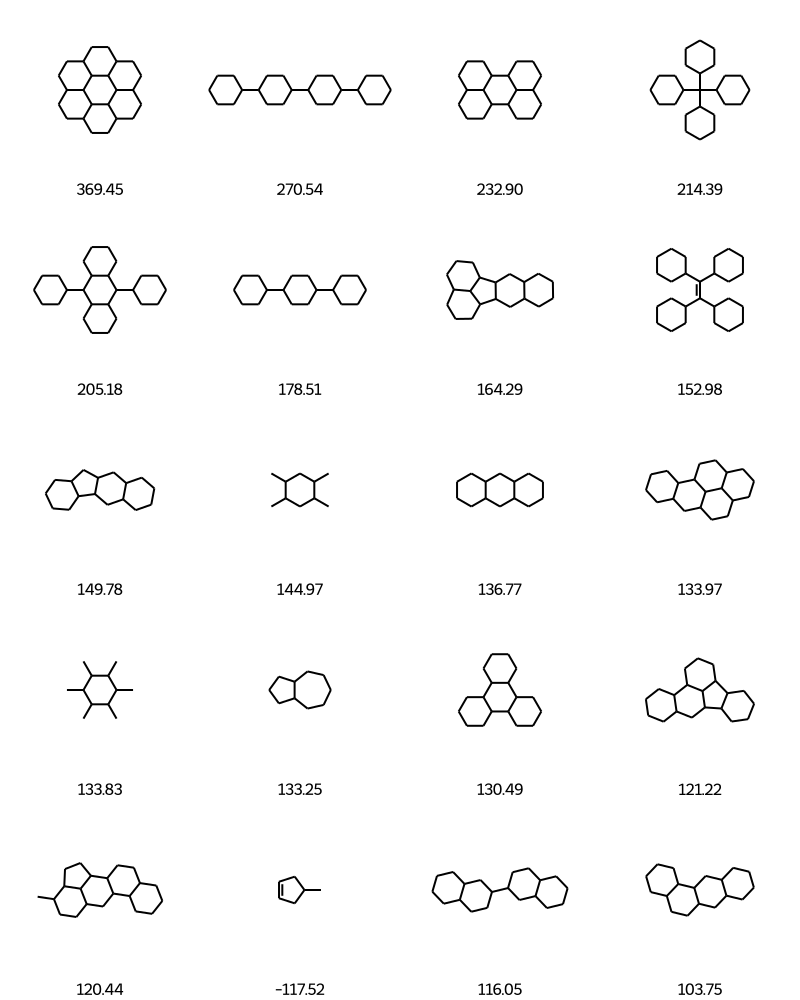

In [98]:
# Display the 10 most badly predicted molecules 
# Calculate residuals
residuals_gb = y_validation - prediciton

# Create a DataFrame with SMILES, actual values, predictions, and residuals
results_df = pd.DataFrame({
    'SMILES': validation['SMILES'],
    'Actual': y_validation,
    'Predicted': prediciton,
    'Residuals': residuals_gb
})

# Sort by absolute residuals to find the worst predictions
results_df['Absolute_Residuals'] = results_df['Residuals'].abs()
sorted_results_df = results_df.sort_values(by='Absolute_Residuals', ascending=False)

# Get the top 20 entries with the worst predictions
worst_predictions = sorted_results_df.head(20)


# Convert SMILES to RDKit molecule objects
molecules = [Chem.MolFromSmiles(smile) for smile in worst_predictions['SMILES']]

# Draw the molecules
Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(200, 200), legends=[f"{x:.2f}" for x in worst_predictions['Residuals']])




## Try with LGBM

In [39]:
# Separating the features and the target variable
X = selected_rows.drop(columns=['smiles', 'mpC'])  # Features (descriptors)
X = X.dropna(axis='columns')
y = selected_rows['mpC']  # Target variable (Melting Point)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define and fit the model
basic_lgbm = LGBMRegressor()
basic_lgbm.fit(X_train, y_train)

# Predictions and evaluation
y_pred_basic = basic_lgbm.predict(X_test)
mse_basic = mean_squared_error(y_test, y_pred_basic)
r2_basic = r2_score(y_test, y_pred_basic)
print(f"Basic LGBM - MSE: {mse_basic:.2f}, R2: {r2_basic:.2f}")

Basic LGBM - MSE: 1051.26, R2: 0.79


In [39]:
"""
# Define the model
lgbm = LGBMRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'learning_rate': [0.1, 0.15],
    'n_estimators': [50, 100, 200],
    'max_depth': [-1, 3],
    'num_leaves': [20, 30, 40],
    'min_child_samples': [10, 20]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_lgbm = grid_search.best_estimator_

# Predictions and evaluation
y_pred_lgbm = best_lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"After tuning - MSE: {mse_lgbm:.2f}, R2: {r2_lgbm:.2f}")
"""

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END learning_rate=0.1, max_depth=-1, min_child_samples=10, n_estimators=50, num_leaves=20; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=-1, min_child_samples=10, n_estimators=50, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=-1, min_child_samples=10, n_estimators=50, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=-1, min_child_samples=10, n_estimators=50, num_leaves=30; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=-1, min_child_samples=10, n_estimators=50, num_leaves=30; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=-1, min_child_samples=10, n_estimators=50, num_leaves=30; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=-1, min_child_samples=10, n_estimators=50, num_leaves=40; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=-1, min_child_samples=10, n_estimators=50, num_leaves=40; total time=   0.2s
[CV] END learning_

In [40]:
"""
results_df = pd.DataFrame(grid_search.cv_results_)
useful_cols = ['param_learning_rate', 'param_n_estimators', 'param_max_depth', 'param_num_leaves', 'param_min_child_samples', 'mean_test_score', 'rank_test_score']
sorted_df = results_df[useful_cols].sort_values('mean_test_score', ascending=False)

sorted_df.head(10)
"""

"\nresults_df = pd.DataFrame(grid_search.cv_results_)\nuseful_cols = ['param_learning_rate', 'param_n_estimators', 'param_max_depth', 'param_num_leaves', 'param_min_child_samples', 'mean_test_score', 'rank_test_score']\nsorted_df = results_df[useful_cols].sort_values('mean_test_score', ascending=False)\n\nsorted_df.head(10)\n"

After tuning LGBM Regressor - MSE: 1211.29, R2: 0.79


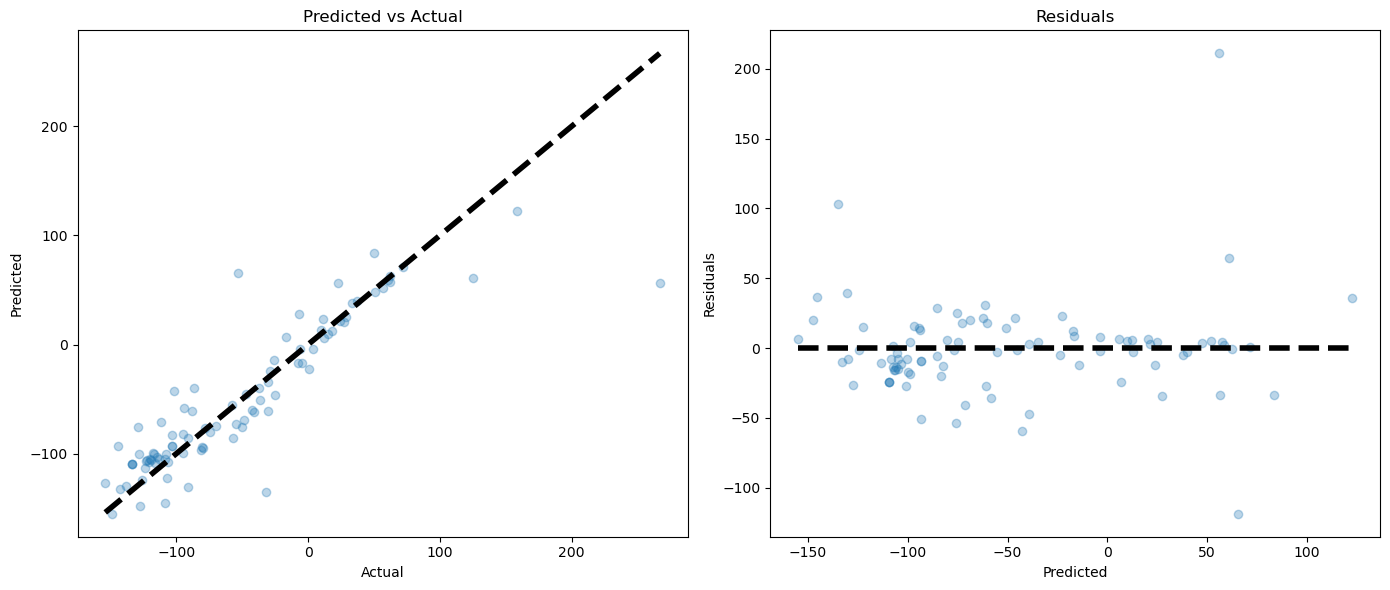

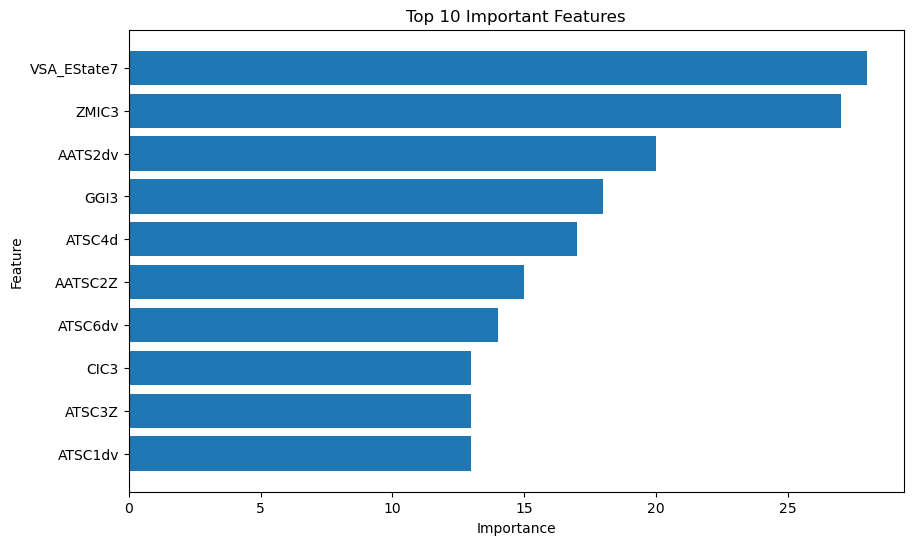

In [41]:
# Separating the features and the target variable
X = selected_rows.drop(columns=['smiles', 'mpC'])  
X = X.dropna(axis='columns')
y = selected_rows['mpC']  

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating the model with the best parameters from the tuning
best_lgbm = LGBMRegressor(learning_rate=0.1, max_depth=-1, min_child_samples=10, n_estimators=50, num_leaves=20)

# Fitting the model
best_lgbm.fit(X_train, y_train)

# Making predictions
y_pred = best_lgbm.predict(X_test)



# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning LGBM Regressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Residuals
residuals = y_test - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.3)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances = best_lgbm.feature_importances_
features = np.array(X_train.columns)
df_feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
df_sorted = df_feature_importances.sort_values('importance', ascending=False).head(10)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['feature'], df_sorted['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()
